In [1]:
'''
Simple bidding network
Train using existing models
    1. get random cards
    2. for each player, evaluate the win rate assume they get the random public cards and become landlord
    3. X: random cards without public cards, Y: win rate
'''
import torch
import random
from collections import Counter
from model_utils import *
from base_utils import *
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from matplotlib import pyplot as plt

In [2]:
def init_game_3card_nolandlord(): # landlord has 3 more cards, which are visible to all
    st = '3333444455556666777788889999XXXXJJJJQQQQKKKKAAAA2222BR'
    idx = list(range(54))
    random.shuffle(idx)
    L = ''.join([st[i] for i in idx[:17]])
    B = ''.join([st[i] for i in idx[17:20]]) # the three cards that are visible to all
    U = ''.join([st[i] for i in idx[20:37]])
    D = ''.join([st[i] for i in idx[37:]])
    Lst = str2state_1D(L)
    Ust = str2state_1D(U)
    Dst = str2state_1D(D)
    Bst = str2state_1D(B)
    return [Lst,Ust,Dst,Bst]

In [3]:
class BidModel(nn.Module):
    def __init__(self, input_size=15, hidden_size=128, num_hidden_layers=4, output_size=1):
        super(BidModel, self).__init__()
        
        # Define the input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Define the hidden layers
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        
        # Define the output layer
        self.output_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Apply the input layer with ReLU activation
        x = F.relu(self.input_layer(x))
        
        # Apply each hidden layer with ReLU activation
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        # Apply the output layer
        x = torch.sigmoid(self.output_layer(x))
        
        return x

In [4]:
# load models

name = 'H15-V2_3.0'
mfiles = [int(f[-13:-3]) for f in os.listdir(os.path.join('models')) if name + '_' in f]

if len(mfiles) == 0:
    v_M = f'{name}_{str(0).zfill(10)}'
else:
    v_M = f'{name}_{str(max(mfiles)).zfill(10)}'

SLM = Network_Pcard_V2_2_BN_dropout(15+7, 7, y=1, x=15, lstmsize=256, hiddensize=512)
QV = Network_Qv_Universal_V1_2_BN_dropout(11*15,256,512)

SLM.load_state_dict(torch.load(os.path.join('models',f'SLM_{v_M}.pt')))
QV.load_state_dict(torch.load(os.path.join('models',f'QV_{v_M}.pt')))

SLM.eval()
QV.eval()



print('Model version:', v_M)

Model version: H15-V2_3.0_0450000000


In [5]:
# generate data
def generate_dataset(SLM,QV, size=128, device='cpu'):
    if device == 'cuda':
        dtypem=torch.float16
        SLM.to(dtypem).to('cuda')
        QV.to(dtypem).to('cuda')
    else:
        dtypem=torch.float32

    simulation_batch_size = size
    Init_states = [init_game_3card_nolandlord() for _ in range(simulation_batch_size)]

    Cards = torch.stack([torch.stack(ist[:-1],dim=0) for ist in Init_states],dim=0)
    Qvalues = torch.zeros((simulation_batch_size,3,1))

    for Tidx in (0,1,2): # all players try landlord

        model_inputs = []
        model_idxs = []
        acts_list = []
        for iin, _ in enumerate(range(simulation_batch_size)):

            #playerstate, model = Init_states[_][Tidx], Models[Tidx] # Same model should be used for all Active
            playerstate = Init_states[_][Tidx] + Init_states[_][-1]

            #print(Turn)
            visible = Init_states[_][-1] # 3 cards from landlord, fixed for one full game

            # use unavail_player instead of CC
            played_cards = torch.zeros((3,15))

            # get actions
            acts = avail_actions_cpp('',(0,0),playerstate,True)

            # add states and visible to big state
            Bigstate = torch.cat([playerstate.unsqueeze(0),
                                    #str2state_1D(unavail[_]).unsqueeze(0),
                                    torch.zeros(15).unsqueeze(0),
                                    #CC,
                                    played_cards, # new feature
                                    visible.unsqueeze(0), # new feature
                                    torch.full((1, 15), 0),
                                    torch.zeros((15,15))])
            Bigstate = Bigstate.unsqueeze(1) # model is not changed, so unsqueeze here

            # generate inputs
            model_inputs.append(Bigstate.unsqueeze(0))
            model_idxs.append(len(acts))
            acts_list.append(acts)

        model_inputs = torch.concat(model_inputs)

        # predict state (SL)
        model_inter, lstm_out = SLM(
            model_inputs.to(dtypem).to(device)
            )
        model_inter = model_inter.to('cpu', torch.float32)
        lstm_out = lstm_out.to('cpu', torch.float32)

        # use all of model inputs
        model_inter = torch.concat([model_inputs[:,0:8,0].view(model_inputs.size(0), -1), # self
                                    model_inter, # upper and lower states
                                    #role,
                                    lstm_out, # lstm encoded history
                                    ],dim=-1)
        model_input2 = []

        for i, mi in enumerate(model_inter):
            input_i = torch.stack([torch.cat((mi,str2state_1D(a[0]))) for a in acts_list[i]])
            model_input2.append(input_i)

        model_output = QV(torch.cat(model_input2).to(dtypem).to(device)).to('cpu').to(torch.float32).flatten()

        # evaluate best win rate
        for iout, _ in enumerate(range(simulation_batch_size)):

            idx_start = sum(model_idxs[:iout])
            idx_end = sum(model_idxs[:iout+1])

            # get q values
            output = model_output[idx_start:idx_end].clone().detach()
            q = torch.max(output)
            
            Qvalues[_,Tidx,0] = q

    torch.cuda.empty_cache()
    return Cards, Qvalues

In [6]:
def train_model(device, model, criterion, loader, nep, optimizer):
    #scaler = torch.cuda.amp.GradScaler()
    model.to(device)
    model.train()  # Set the model to training mode
    for epoch in range(nep):
        running_loss = 0.0
        
        for inputs, targets in tqdm(loader):
            inputs, targets = inputs.to(torch.float32).to(device), targets.to(torch.float32).to(device)
            
            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize
            
            running_loss += loss.item()
        
        # Calculate the average loss per batch over the epoch
        epoch_loss = running_loss / len(loader)
        print(f"Epoch {epoch+1}/{nep}, Training Loss: {epoch_loss:.4f}")
    return model

In [7]:
'''if torch.get_num_threads() > 1:
    torch.set_num_threads(1)
    torch.set_num_interop_threads(1)'''

'if torch.get_num_threads() > 1:\n    torch.set_num_threads(1)\n    torch.set_num_interop_threads(1)'

In [8]:
EV = BidModel(input_size=15, hidden_size=128, num_hidden_layers=5, output_size=1)
EV.load_state_dict(torch.load(os.path.join('data',f'EV_best.pt')))

<All keys matched successfully>

In [9]:
for i in range(200):
    print(f'---{i}---              ',end='\r')
    with torch.inference_mode():
        Cards, Qvalues = generate_dataset(SLM,QV,2048)
    train_loader = DataLoader(TensorDataset(Cards.reshape(-1, 15), Qvalues.reshape(-1, 1)), 
                            batch_size=512, shuffle=True, num_workers=0, pin_memory=True)
    opt = torch.optim.Adam(EV.parameters(), lr=0.00001,weight_decay = 1e-10)
    EV = train_model('cuda', EV, torch.nn.MSELoss(), train_loader, 10, opt)

100%|██████████| 12/12 [00:00<00:00, 101.48it/s]


Epoch 1/10, Training Loss: 0.0392


100%|██████████| 12/12 [00:00<00:00, 296.88it/s]


Epoch 2/10, Training Loss: 0.0390


100%|██████████| 12/12 [00:00<00:00, 307.86it/s]


Epoch 3/10, Training Loss: 0.0389


100%|██████████| 12/12 [00:00<00:00, 319.05it/s]


Epoch 4/10, Training Loss: 0.0389


100%|██████████| 12/12 [00:00<00:00, 300.57it/s]


Epoch 5/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 302.72it/s]


Epoch 6/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 316.28it/s]


Epoch 7/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 283.58it/s]


Epoch 8/10, Training Loss: 0.0387


100%|██████████| 12/12 [00:00<00:00, 288.81it/s]


Epoch 9/10, Training Loss: 0.0387


100%|██████████| 12/12 [00:00<00:00, 316.85it/s]


Epoch 10/10, Training Loss: 0.0387


100%|██████████| 12/12 [00:00<00:00, 289.57it/s]


Epoch 1/10, Training Loss: 0.0379


100%|██████████| 12/12 [00:00<00:00, 314.76it/s]


Epoch 2/10, Training Loss: 0.0378


100%|██████████| 12/12 [00:00<00:00, 318.24it/s]


Epoch 3/10, Training Loss: 0.0378


100%|██████████| 12/12 [00:00<00:00, 326.18it/s]


Epoch 4/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 323.91it/s]


Epoch 5/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 311.71it/s]


Epoch 6/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 324.41it/s]


Epoch 7/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 312.60it/s]


Epoch 8/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 317.64it/s]


Epoch 9/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 321.00it/s]


Epoch 10/10, Training Loss: 0.0375


100%|██████████| 12/12 [00:00<00:00, 308.32it/s]


Epoch 1/10, Training Loss: 0.0386


100%|██████████| 12/12 [00:00<00:00, 299.71it/s]


Epoch 2/10, Training Loss: 0.0385


100%|██████████| 12/12 [00:00<00:00, 307.45it/s]


Epoch 3/10, Training Loss: 0.0385


100%|██████████| 12/12 [00:00<00:00, 308.94it/s]


Epoch 4/10, Training Loss: 0.0385


100%|██████████| 12/12 [00:00<00:00, 305.18it/s]


Epoch 5/10, Training Loss: 0.0384


100%|██████████| 12/12 [00:00<00:00, 303.76it/s]


Epoch 6/10, Training Loss: 0.0384


100%|██████████| 12/12 [00:00<00:00, 312.88it/s]


Epoch 7/10, Training Loss: 0.0384


100%|██████████| 12/12 [00:00<00:00, 322.38it/s]


Epoch 8/10, Training Loss: 0.0383


100%|██████████| 12/12 [00:00<00:00, 124.65it/s]


Epoch 9/10, Training Loss: 0.0383


100%|██████████| 12/12 [00:00<00:00, 307.18it/s]


Epoch 10/10, Training Loss: 0.0383


100%|██████████| 12/12 [00:00<00:00, 309.79it/s]


Epoch 1/10, Training Loss: 0.0386


100%|██████████| 12/12 [00:00<00:00, 307.08it/s]


Epoch 2/10, Training Loss: 0.0386


100%|██████████| 12/12 [00:00<00:00, 323.81it/s]


Epoch 3/10, Training Loss: 0.0385


100%|██████████| 12/12 [00:00<00:00, 314.65it/s]


Epoch 4/10, Training Loss: 0.0385


100%|██████████| 12/12 [00:00<00:00, 304.55it/s]


Epoch 5/10, Training Loss: 0.0384


100%|██████████| 12/12 [00:00<00:00, 319.84it/s]


Epoch 6/10, Training Loss: 0.0384


100%|██████████| 12/12 [00:00<00:00, 329.68it/s]


Epoch 7/10, Training Loss: 0.0384


100%|██████████| 12/12 [00:00<00:00, 322.47it/s]


Epoch 8/10, Training Loss: 0.0383


100%|██████████| 12/12 [00:00<00:00, 326.82it/s]


Epoch 9/10, Training Loss: 0.0383


100%|██████████| 12/12 [00:00<00:00, 330.45it/s]


Epoch 10/10, Training Loss: 0.0383


100%|██████████| 12/12 [00:00<00:00, 310.70it/s]


Epoch 1/10, Training Loss: 0.0391


100%|██████████| 12/12 [00:00<00:00, 311.22it/s]


Epoch 2/10, Training Loss: 0.0391


100%|██████████| 12/12 [00:00<00:00, 295.36it/s]


Epoch 3/10, Training Loss: 0.0390


100%|██████████| 12/12 [00:00<00:00, 291.79it/s]


Epoch 4/10, Training Loss: 0.0390


100%|██████████| 12/12 [00:00<00:00, 296.29it/s]


Epoch 5/10, Training Loss: 0.0389


100%|██████████| 12/12 [00:00<00:00, 316.82it/s]


Epoch 6/10, Training Loss: 0.0389


100%|██████████| 12/12 [00:00<00:00, 314.23it/s]


Epoch 7/10, Training Loss: 0.0389


100%|██████████| 12/12 [00:00<00:00, 294.85it/s]


Epoch 8/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 310.62it/s]


Epoch 9/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 309.83it/s]


Epoch 10/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 303.91it/s]


Epoch 1/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 321.83it/s]


Epoch 2/10, Training Loss: 0.0375


100%|██████████| 12/12 [00:00<00:00, 318.69it/s]


Epoch 3/10, Training Loss: 0.0374


100%|██████████| 12/12 [00:00<00:00, 308.60it/s]


Epoch 4/10, Training Loss: 0.0373


100%|██████████| 12/12 [00:00<00:00, 328.55it/s]


Epoch 5/10, Training Loss: 0.0373


100%|██████████| 12/12 [00:00<00:00, 328.43it/s]


Epoch 6/10, Training Loss: 0.0373


100%|██████████| 12/12 [00:00<00:00, 325.65it/s]


Epoch 7/10, Training Loss: 0.0373


100%|██████████| 12/12 [00:00<00:00, 124.61it/s]


Epoch 8/10, Training Loss: 0.0372


100%|██████████| 12/12 [00:00<00:00, 328.58it/s]


Epoch 9/10, Training Loss: 0.0372


100%|██████████| 12/12 [00:00<00:00, 311.48it/s]


Epoch 10/10, Training Loss: 0.0372


100%|██████████| 12/12 [00:00<00:00, 305.11it/s]


Epoch 1/10, Training Loss: 0.0375


100%|██████████| 12/12 [00:00<00:00, 289.37it/s]


Epoch 2/10, Training Loss: 0.0374


100%|██████████| 12/12 [00:00<00:00, 298.15it/s]


Epoch 3/10, Training Loss: 0.0374


100%|██████████| 12/12 [00:00<00:00, 294.67it/s]


Epoch 4/10, Training Loss: 0.0373


100%|██████████| 12/12 [00:00<00:00, 306.89it/s]


Epoch 5/10, Training Loss: 0.0373


100%|██████████| 12/12 [00:00<00:00, 271.33it/s]


Epoch 6/10, Training Loss: 0.0373


100%|██████████| 12/12 [00:00<00:00, 274.81it/s]


Epoch 7/10, Training Loss: 0.0373


100%|██████████| 12/12 [00:00<00:00, 272.79it/s]


Epoch 8/10, Training Loss: 0.0372


100%|██████████| 12/12 [00:00<00:00, 288.23it/s]


Epoch 9/10, Training Loss: 0.0372


100%|██████████| 12/12 [00:00<00:00, 313.72it/s]


Epoch 10/10, Training Loss: 0.0372


100%|██████████| 12/12 [00:00<00:00, 295.12it/s]


Epoch 1/10, Training Loss: 0.0392


100%|██████████| 12/12 [00:00<00:00, 280.82it/s]


Epoch 2/10, Training Loss: 0.0391


100%|██████████| 12/12 [00:00<00:00, 323.61it/s]


Epoch 3/10, Training Loss: 0.0391


100%|██████████| 12/12 [00:00<00:00, 294.39it/s]


Epoch 4/10, Training Loss: 0.0391


100%|██████████| 12/12 [00:00<00:00, 312.58it/s]


Epoch 5/10, Training Loss: 0.0390


100%|██████████| 12/12 [00:00<00:00, 294.34it/s]


Epoch 6/10, Training Loss: 0.0390


100%|██████████| 12/12 [00:00<00:00, 308.03it/s]


Epoch 7/10, Training Loss: 0.0390


100%|██████████| 12/12 [00:00<00:00, 311.30it/s]


Epoch 8/10, Training Loss: 0.0390


100%|██████████| 12/12 [00:00<00:00, 304.28it/s]


Epoch 9/10, Training Loss: 0.0389


100%|██████████| 12/12 [00:00<00:00, 307.88it/s]


Epoch 10/10, Training Loss: 0.0389


100%|██████████| 12/12 [00:00<00:00, 268.64it/s]


Epoch 1/10, Training Loss: 0.0379


100%|██████████| 12/12 [00:00<00:00, 262.83it/s]


Epoch 2/10, Training Loss: 0.0379


100%|██████████| 12/12 [00:00<00:00, 288.12it/s]


Epoch 3/10, Training Loss: 0.0378


100%|██████████| 12/12 [00:00<00:00, 288.48it/s]


Epoch 4/10, Training Loss: 0.0378


100%|██████████| 12/12 [00:00<00:00, 296.75it/s]


Epoch 5/10, Training Loss: 0.0378


100%|██████████| 12/12 [00:00<00:00, 98.08it/s]


Epoch 6/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 273.83it/s]


Epoch 7/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 290.87it/s]


Epoch 8/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 274.20it/s]


Epoch 9/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 301.61it/s]


Epoch 10/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 269.16it/s]


Epoch 1/10, Training Loss: 0.0380


100%|██████████| 12/12 [00:00<00:00, 293.46it/s]


Epoch 2/10, Training Loss: 0.0379


100%|██████████| 12/12 [00:00<00:00, 304.13it/s]


Epoch 3/10, Training Loss: 0.0379


100%|██████████| 12/12 [00:00<00:00, 269.98it/s]


Epoch 4/10, Training Loss: 0.0378


100%|██████████| 12/12 [00:00<00:00, 295.35it/s]


Epoch 5/10, Training Loss: 0.0378


100%|██████████| 12/12 [00:00<00:00, 282.88it/s]


Epoch 6/10, Training Loss: 0.0378


100%|██████████| 12/12 [00:00<00:00, 264.45it/s]


Epoch 7/10, Training Loss: 0.0378


100%|██████████| 12/12 [00:00<00:00, 279.70it/s]


Epoch 8/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 300.52it/s]


Epoch 9/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 303.01it/s]


Epoch 10/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 321.76it/s]


Epoch 1/10, Training Loss: 0.0379


100%|██████████| 12/12 [00:00<00:00, 328.16it/s]


Epoch 2/10, Training Loss: 0.0378


100%|██████████| 12/12 [00:00<00:00, 337.93it/s]


Epoch 3/10, Training Loss: 0.0378


100%|██████████| 12/12 [00:00<00:00, 325.41it/s]


Epoch 4/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 282.07it/s]


Epoch 5/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 272.58it/s]


Epoch 6/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 309.87it/s]


Epoch 7/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 326.08it/s]


Epoch 8/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 328.68it/s]


Epoch 9/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 335.15it/s]


Epoch 10/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 326.87it/s]


Epoch 1/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 334.15it/s]


Epoch 2/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 330.42it/s]


Epoch 3/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 342.96it/s]


Epoch 4/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 340.54it/s]


Epoch 5/10, Training Loss: 0.0375


100%|██████████| 12/12 [00:00<00:00, 323.43it/s]


Epoch 6/10, Training Loss: 0.0375


100%|██████████| 12/12 [00:00<00:00, 329.14it/s]


Epoch 7/10, Training Loss: 0.0375


100%|██████████| 12/12 [00:00<00:00, 121.34it/s]


Epoch 8/10, Training Loss: 0.0374


100%|██████████| 12/12 [00:00<00:00, 337.71it/s]


Epoch 9/10, Training Loss: 0.0374


100%|██████████| 12/12 [00:00<00:00, 347.51it/s]


Epoch 10/10, Training Loss: 0.0374


100%|██████████| 12/12 [00:00<00:00, 300.38it/s]


Epoch 1/10, Training Loss: 0.0377


100%|██████████| 12/12 [00:00<00:00, 334.71it/s]


Epoch 2/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 343.12it/s]


Epoch 3/10, Training Loss: 0.0376


100%|██████████| 12/12 [00:00<00:00, 340.71it/s]


Epoch 4/10, Training Loss: 0.0375


100%|██████████| 12/12 [00:00<00:00, 343.42it/s]


Epoch 5/10, Training Loss: 0.0375


100%|██████████| 12/12 [00:00<00:00, 344.03it/s]


Epoch 6/10, Training Loss: 0.0375


100%|██████████| 12/12 [00:00<00:00, 339.76it/s]


Epoch 7/10, Training Loss: 0.0374


100%|██████████| 12/12 [00:00<00:00, 341.19it/s]


Epoch 8/10, Training Loss: 0.0374


100%|██████████| 12/12 [00:00<00:00, 293.81it/s]


Epoch 9/10, Training Loss: 0.0374


100%|██████████| 12/12 [00:00<00:00, 315.86it/s]


Epoch 10/10, Training Loss: 0.0374


100%|██████████| 12/12 [00:00<00:00, 291.84it/s]


Epoch 1/10, Training Loss: 0.0391


100%|██████████| 12/12 [00:00<00:00, 281.94it/s]


Epoch 2/10, Training Loss: 0.0390


100%|██████████| 12/12 [00:00<00:00, 281.23it/s]


Epoch 3/10, Training Loss: 0.0390


100%|██████████| 12/12 [00:00<00:00, 264.85it/s]


Epoch 4/10, Training Loss: 0.0390


100%|██████████| 12/12 [00:00<00:00, 278.63it/s]


Epoch 5/10, Training Loss: 0.0389


100%|██████████| 12/12 [00:00<00:00, 294.49it/s]


Epoch 6/10, Training Loss: 0.0389


100%|██████████| 12/12 [00:00<00:00, 283.32it/s]


Epoch 7/10, Training Loss: 0.0389


100%|██████████| 12/12 [00:00<00:00, 293.34it/s]


Epoch 8/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 277.57it/s]


Epoch 9/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 268.66it/s]


Epoch 10/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 260.60it/s]


Epoch 1/10, Training Loss: 0.0390


100%|██████████| 12/12 [00:00<00:00, 271.54it/s]


Epoch 2/10, Training Loss: 0.0390


100%|██████████| 12/12 [00:00<00:00, 99.92it/s]


Epoch 3/10, Training Loss: 0.0389


100%|██████████| 12/12 [00:00<00:00, 292.19it/s]


Epoch 4/10, Training Loss: 0.0389


100%|██████████| 12/12 [00:00<00:00, 241.27it/s]


Epoch 5/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 230.62it/s]


Epoch 6/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 282.38it/s]


Epoch 7/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 287.33it/s]


Epoch 8/10, Training Loss: 0.0388


100%|██████████| 12/12 [00:00<00:00, 267.84it/s]


Epoch 9/10, Training Loss: 0.0387


100%|██████████| 12/12 [00:00<00:00, 273.90it/s]


Epoch 10/10, Training Loss: 0.0387


KeyboardInterrupt: 

In [10]:
Cardstest, Qvaluestest = generate_dataset(SLM,QV,512,'cpu')

In [11]:
Cardstest.reshape(-1, 15).shape

torch.Size([1536, 15])

In [12]:
EV.eval()
EV.to('cpu')

BidModel(
  (input_layer): Linear(in_features=15, out_features=128, bias=True)
  (hidden_layers): ModuleList(
    (0-3): 4 x Linear(in_features=128, out_features=128, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [13]:
with torch.inference_mode():
    ypred = EV(Cardstest.reshape(-1, 15))
    ytrue = Qvaluestest.reshape(-1,1)

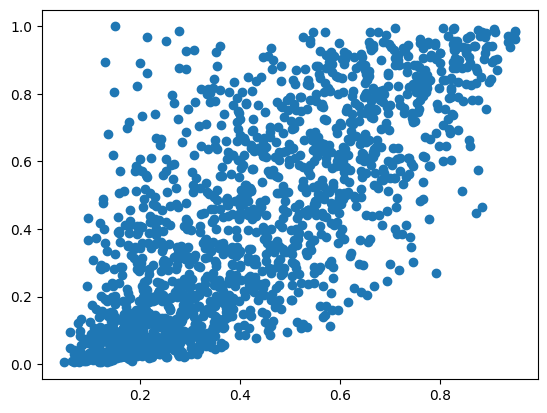

In [14]:
plt.scatter(ypred.numpy(), ytrue.numpy())

In [15]:
torch.mean((ypred-ytrue)**2)

tensor(0.0394)

In [16]:
torch.save(EV.state_dict(),os.path.join('data',f'EV_best.pt'))